# Particle Swarm Optimization
(originaly proposed to simulate birds searching for food, the movement of fishes’ shoal, etc.) is able to simulate behaviors of swarms in order to optimize a numeric problem iteratively.

Imagine a group of birds looking for food.

They don't know exactly where the food is.

Each bird looks around and shares with others how good its spot is.

Over time, the birds move toward the best locations discovered so far.

Eventually, the whole group finds the best spot.

## In PSO:

Each "particle" represents a possible solution.

Particles move through the solution space.

Each particle remembers:

The best solution it has found so far (pbest — personal best).

The best solution found by any particle (gbest — global best).

Based on these, each particle updates its position and velocity to "fly" towards better solutions.


### Consisting in the constant search of best solution:

1- the method moves the particles  (x,y) position with a certain velocity calculated in every iteration.

2- Each particle’s movement has the influence of his own the best known position and also the best known position in the space-search.

3- The final result expected is that the particle swarm converge to the best solution.

=> It’s important to mention that PSO doesn’t use Gradient Descent, so it can be used to non linear problems once it doesn’t require that the problem have to be differentiable

# ALGORITHM
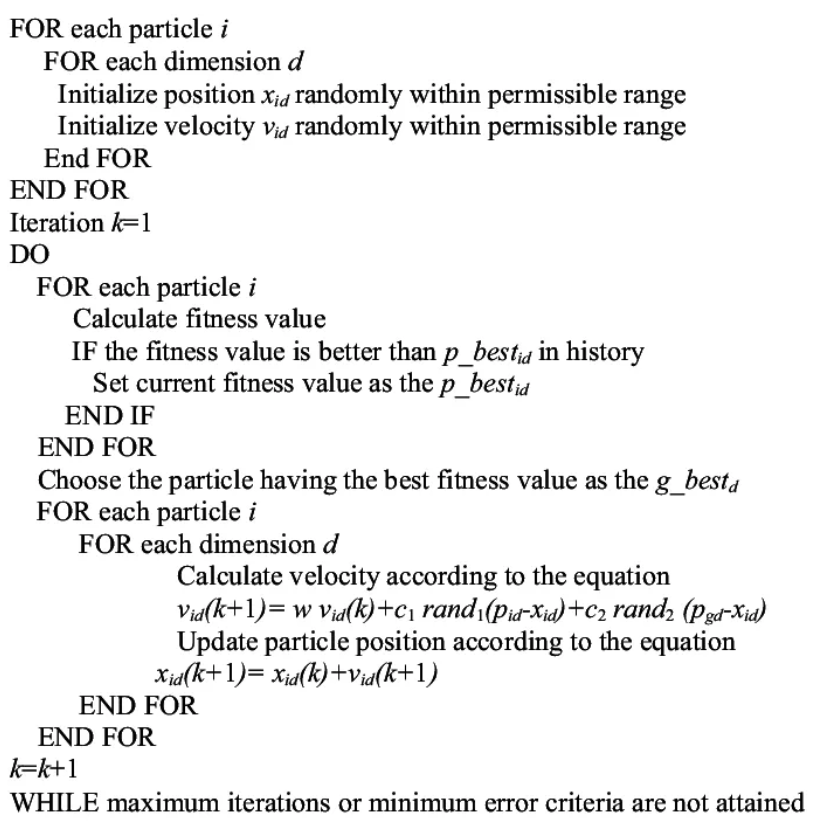

1-  it initializes the particles’ positions with a random uniform distribution within a permissible range for all its dimensions

2- for each particle, it calculates its fitness value and compared with his own best position (The p_best value is the best position of that specific particle has ever been)

3-  it chooses the best position of all particles in g_best



*   Vᵢ(k+1) is the next iteration velocity
*   W is an inertial parameter. This parameter affects the movement propagation given by the last velocity value.



*   C₁ and C₂ are acceleration coefficients. C₁ value gives the importance of personal best value and C₂ is the importance of social best value.
*   Pᵢ is the best individual position and Pg is the best position of all particles. In the equation, is measured the distance of each of these parameters to the particle's actual position.


*   rand₁ and rand₂ are random numbers where 0 ≤ rand ≤ 1 and they control the influence of each value: Social and individual as shown below.



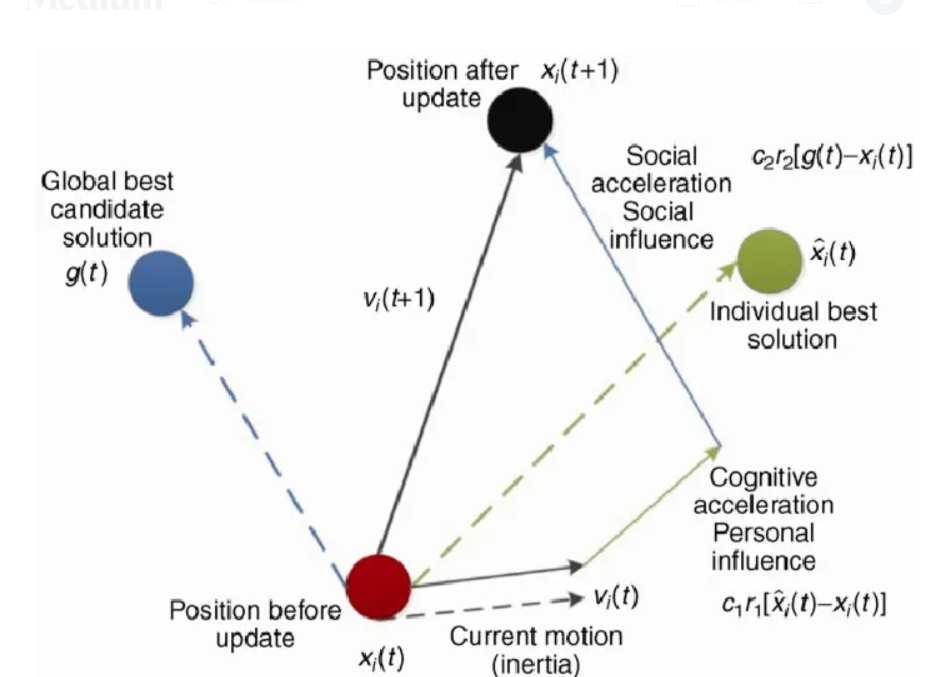


# Data Loading

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score
from itertools import product
import time
from datetime import timedelta

In [2]:
df = pd.read_csv('Breast.csv')
df.head()

,1,-0.299,0.09300000000000001,-0.215,-0.5660000000000001,-0.596,-0.195,0.039,-0.409,-0.35200000000000004,...,-0.96.1,-0.21100000000000002.16,0.155.27,-0.095.49,-0.025.59,-0.037000000000000005.52,0.215.19,0.307.8,0.321.8,1.1
0,2,-0.081,0.009,-0.091,-0.518,-0.502,-0.149,0.098,-0.090,0.138,...,-0.531,-0.020,0.014,-0.123,0.148,0.024,-0.070,-0.209,0.105,1
1,3,-0.125,0.070,-0.006,-0.575,-0.585,-0.183,0.102,0.023,-0.350,...,-0.883,-0.159,0.022,0.006,-0.086,0.019,0.026,-0.822,0.199,1
2,4,-0.270,0.123,0.056,-0.499,-0.402,-0.099,-0.145,-0.103,0.181,...,-0.044,-0.096,0.018,0.000,0.076,0.057,-0.016,-0.360,-0.038,1
3,5,-0.141,0.025,-0.031,-0.465,-0.533,-0.065,0.101,-0.008,-0.019,...,0.280,-0.088,0.043,0.207,-0.124,-0.041,-0.077,-0.432,-0.015,1
4,6,-0.149,0.068,-0.084,-0.557,-0.595,-0.062,-0.056,-0.009,0.031,...,-0.258,-0.135,-0.013,-0.045,-0.114,0.643,-0.162,-0.976,-0.078,1


In [3]:
df.shape

(96, 24483)

The PSO algorithm I've implemented for feature selection works as follows:

# Initialization:

Creates a swarm of particles, each representing a potential solution (a subset of features)
Each particle has a position (which features to select) and a velocity (to guide movement)


# Fitness Function:

Evaluates each solution based on classification accuracy and feature count
Uses a penalty term to prefer solutions with fewer features


# Optimization Process:

Updates particle positions and velocities iteratively
Maintains personal best for each particle and global best across all particles
Uses sigmoid function to convert continuous values to binary feature selections


# Output:

Returns the indices of selected features and a binary mask




1- Load dataset into a suitable format (numpy array or pandas DataFrame)

2- Split the features (X) and target (y)

3- Run the PSO algorithm with desired parameters

The hyperparameters i can adjust include:

Number of particles:** More particles = better exploration but higher computational cost**

Maximum iterations: **More iterations = better convergence but longer runtime**

**Inertia weight (w): Controls influence of previous velocity**

**Cognitive (c1) and social (c2) coefficients: Balance exploration vs. exploitation**

# Preprocessing

In [4]:
# Extract features and target
X = df.iloc[:, :-1].values  # All columns except the last one
y = df.iloc[:, -1].values   # Last column as target

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


# Initial Evaluation With KNN

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
clf = KNeighborsClassifier(n_neighbors=5)
clf.fit(X_train, y_train)
final_accuracy = clf.score(X_test, y_test)
print(f"Final accuracy with selected features: {final_accuracy:.4f}")

Final accuracy with selected features: 0.4500


## Initialisation

In [7]:
# PSO parameters
n_particles = 20       # Number of particles in swarm
max_iter = 50          # Maximum iterations
n_features = X.shape[1]  # Number of features

# PSO coefficients
w = 0.7    # Inertia weight
c1 = 1.5   # Cognitive coefficient
c2 = 1.5   # Social coefficient
binary_threshold = 0.5  # Threshold for binary decision

# Initialize particle positions and velocities
particles_pos = np.random.rand(n_particles, n_features)
velocities = np.zeros((n_particles, n_features))

# Initialize personal best positions and scores
pbest_pos = particles_pos.copy()
pbest_scores = np.zeros(n_particles)

# Initialize global best position and score
gbest_pos = np.zeros(n_features)
gbest_score = -np.inf
best_feature_count = 0

# Sigmoid function for binary conversion

In [8]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))


## Start PSO iterations

In [9]:
print(f"Starting PSO feature selection with {n_particles} particles for {max_iter} iterations")
print(f"Dataset shape: {X.shape}")

for iteration in range(max_iter):
    print(f"Iteration {iteration+1}/{max_iter}")

    # Calculate fitness for each particle
    for i in range(n_particles):
        # Convert continuous position to binary (1 = select feature, 0 = ignore)
        binary_position = (particles_pos[i] > binary_threshold).astype(int)

        # Count selected features
        n_selected_features = np.sum(binary_position)

        # If no features selected, assign poor fitness
        if n_selected_features == 0:
            fitness = 0.0
        else:
            # Select features
            selected_features = X_scaled[:, binary_position == 1]

            # Split data
            X_train, X_test, y_train, y_test = train_test_split(
                selected_features, y, test_size=0.2, random_state=42
            )

            # Build classifier
            clf = KNeighborsClassifier(n_neighbors=5)
            clf.fit(X_train, y_train)

            # Predict and calculate accuracy
            y_pred = clf.predict(X_test)
            accuracy = accuracy_score(y_test, y_pred)

            # Penalize too many features (adjust alpha to control trade-off)
            alpha = 0.01
            fitness = accuracy - alpha * (n_selected_features / n_features)

        # Update personal best
        if fitness > pbest_scores[i]:
            pbest_scores[i] = fitness
            pbest_pos[i] = particles_pos[i].copy()

        # Update global best
        if fitness > gbest_score:
            gbest_score = fitness
            gbest_pos = particles_pos[i].copy()
            # Count features in best solution
            best_feature_count = np.sum(gbest_pos > binary_threshold)
            print(f"  New best solution: accuracy = {fitness:.4f}, features = {best_feature_count}")

    # Update velocities and positions
    r1 = np.random.random((n_particles, n_features))
    r2 = np.random.random((n_particles, n_features))

    # Update velocities
    velocities = (w * velocities +
                  c1 * r1 * (pbest_pos - particles_pos) +
                  c2 * r2 * (gbest_pos - particles_pos))

    # Update positions using sigmoid function for binary decisions
    sigmoid_velocities = sigmoid(velocities)
    rand_matrix = np.random.random((n_particles, n_features))
    particles_pos = (sigmoid_velocities > rand_matrix).astype(float)


Starting PSO feature selection with 20 particles for 50 iterations
Dataset shape: (96, 24482)
Iteration 1/50
  New best solution: accuracy = 0.4450, features = 12341
  New best solution: accuracy = 0.4950, features = 12167
Iteration 2/50
  New best solution: accuracy = 0.4950, features = 12137
Iteration 3/50
  New best solution: accuracy = 0.4950, features = 12136
Iteration 4/50
Iteration 5/50
  New best solution: accuracy = 0.4951, features = 12095
  New best solution: accuracy = 0.4951, features = 12034
Iteration 6/50
Iteration 7/50
Iteration 8/50
Iteration 9/50
Iteration 10/50
Iteration 11/50
  New best solution: accuracy = 0.4951, features = 12019
Iteration 12/50
Iteration 13/50
Iteration 14/50
Iteration 15/50
Iteration 16/50
Iteration 17/50
Iteration 18/50
Iteration 19/50
Iteration 20/50
  New best solution: accuracy = 0.5450, features = 12146
Iteration 21/50
Iteration 22/50
Iteration 23/50
Iteration 24/50
Iteration 25/50
Iteration 26/50
  New best solution: accuracy = 0.5450, fea

In [10]:
# Get final selected features - THIS WAS THE ISSUE, make sure this runs before using best_mask
best_mask = (gbest_pos > binary_threshold).astype(int)
selected_feature_indices = np.where(best_mask == 1)[0]

print("\nPSO completed.")
print(f"Selected {len(selected_feature_indices)} out of {n_features} features")
print(f"Best fitness score: {gbest_score:.4f}")
print("Indices of selected features:", selected_feature_indices)


PSO completed.
Selected 12075 out of 24482 features
Best fitness score: 0.5451
Indices of selected features: [    1     2     3 ... 24478 24480 24481]


## Evaluate final solution

In [11]:
X_selected = X_scaled[:, best_mask == 1]
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)
clf = KNeighborsClassifier(n_neighbors=5)
clf.fit(X_train, y_train)
final_accuracy = clf.score(X_test, y_test)
print(f"Final accuracy with selected features: {final_accuracy:.4f}")

Final accuracy with selected features: 0.5500


In [12]:
# Extract feature names if you want to know which features were selected
selected_feature_names = df.columns[:-1][selected_feature_indices]
print("Selected feature names:", selected_feature_names.tolist())

Selected feature names: ['-0.299', '0.09300000000000001', '-0.215', '-0.5660000000000001', '-0.012', '-0.141', '0.146', '-0.172', '-0.147', '-0.081', '-0.11699999999999999', '-0.054000000000000006', '0.38299999999999995', '0.049', '-0.161', '0.121', '0.021', '0.24600000000000002', '0.006', '-0.085', '0.213', '100', '0.009000000000000001', '-0.024', '0.145', '0.071', '-0.09699999999999999', '0.035', '0.083', '-0.11900000000000001', '-0.087.1', '0.057999999999999996', '0.09300000000000001.1', '0.039.2', '-0.257', '-0.43', '0.27', '-0.018000000000000002', '-0.005.1', '0.006.1', '-0.129', '0.008', '-0.063', '0.054000000000000006', '-0.13699999999999998', '-0.035.1', '0.109', '-0.08', '0.15', '0.324', '-0.03', '-0.207', '0.525', '100.1', '-0.149', '0.036000000000000004', '-0.040999999999999995', '-0.21100000000000002', '-0.23', '-0.076', '0.264', '-0.033', '0.105', '0.193', '0.115', '-0.282', '-0.063.1', '-0.133', '0.155', '0.003', '0.069', '0.083.1', '0.16399999999999998', '0.096', '0.078'

# Comparing classification algorithms

In [6]:
print("\n1. Comparing base models on original dataset...")

# Define models to test
models = {
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'SVM': SVC(kernel='linear', probability=True),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42)
}

# Split data for initial model evaluation
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Evaluate each model
model_results = []
for name, model in models.items():
    print(f"  Training {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    model_results.append({
        'Model': name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    })

    print(f"    {name}: Accuracy = {accuracy:.4f}, F1 = {f1:.4f}")

# Identify best model
model_results_df = pd.DataFrame(model_results)
best_model_name = model_results_df.loc[model_results_df['Accuracy'].idxmax()]['Model']
best_model = models[best_model_name]

print(f"\nBest performing model: {best_model_name}")


1. Comparing base models on original dataset...
  Training KNN...
    KNN: Accuracy = 0.4500, F1 = 0.4120
  Training SVM...
    SVM: Accuracy = 0.6000, F1 = 0.6081
  Training Random Forest...
    Random Forest: Accuracy = 0.4500, F1 = 0.4404
  Training Gradient Boosting...
    Gradient Boosting: Accuracy = 0.9000, F1 = 0.8952
  Training Logistic Regression...
    Logistic Regression: Accuracy = 0.6500, F1 = 0.6581

Best performing model: Gradient Boosting


I will opt for logistic regression and try to optimize its accuracy with pso

# Single-Stage PSO Grid Search
Single-Stage PSO Grid Search

Tries different combinations of:

Alpha penalty (0.05, 0.3, 0.8)

Binary thresholds (0.6 , 0.8)

Number of particles (30, 50)

Maximum iterations (30)

Inertia weights (0.5, 0.7)


For each combination:

Runs the PSO algorithm with those parameters

Calculates accuracy and fitness score

Tracks selected features

Saves results to CSV files for analysis

In [38]:
# Grid search parameters
param_grid = {
    'alpha': [0.05, 0.3, 0.8],  # Expanded alpha range with more penalties
    'binary_threshold': [0.6, 0.8],  # Added higher threshold to be more selective
    'n_particles': [30, 50],  # Added more particles options
    'max_iter': [30],  # Added more iterations for better convergence
    'w': [0.5, 0.7], # Expanded inertia weight range
    'c1': [1.2, 1.8],  # More cognitive coefficient options
    'c2': [1.2, 1.8]   # More social coefficient options
}
# Create all parameter combinations with no duplicates
param_combinations = []
seen = set()

for combo in product(
    param_grid['alpha'],
    param_grid['binary_threshold'],
    param_grid['n_particles'],
    param_grid['max_iter'],
    param_grid['w'],
    param_grid['c1'],
    param_grid['c2']
):
    # Convert to a hashable form to track duplicates
    combo_key = combo
    if combo_key not in seen:
        seen.add(combo_key)
        param_combinations.append({
            'alpha': combo[0],
            'binary_threshold': combo[1],
            'n_particles': combo[2],
            'max_iter': combo[3],
            'w': combo[4],
            'c1': combo[5],
            'c2': combo[6]
        })

# Function to run PSO with specific parameters
def run_pso(alpha, binary_threshold, n_particles, max_iter, w, c1, c2, early_stop_patience=5):
    n_features = X_scaled.shape[1]

    # Initialize particle positions and velocities
    particles_pos = np.random.rand(n_particles, n_features)
    velocities = np.zeros((n_particles, n_features))

    # Initialize personal best positions and scores
    pbest_pos = particles_pos.copy()
    pbest_scores = np.zeros(n_particles)

    # Initialize global best position and score
    gbest_pos = np.zeros(n_features)
    gbest_score = -np.inf

    # Early stopping variables
    best_score_history = -np.inf
    iterations_no_improve = 0
    actual_iterations = 0

    # Start PSO iterations
    for iteration in range(max_iter):
        actual_iterations = iteration + 1
        iteration_best_score = -np.inf

        # Calculate fitness for each particle
        for i in range(n_particles):
            # Convert continuous position to binary (1 = select feature, 0 = ignore)
            binary_position = (particles_pos[i] > binary_threshold).astype(int)

            # Count selected features
            n_selected_features = np.sum(binary_position)

            # If no features selected, assign poor fitness
            if n_selected_features == 0:
                fitness = 0.0
            else:
                # Select features
                selected_features = X_scaled[:, binary_position == 1]

                # Split data
                X_train, X_test, y_train, y_test = train_test_split(
                    selected_features, y, test_size=0.2, random_state=42
                )

                # Build classifier
                clf = LogisticRegression(max_iter=1000, random_state=42)
                clf.fit(X_train, y_train)

                # Predict and calculate accuracy
                y_pred = clf.predict(X_test)
                accuracy = accuracy_score(y_test, y_pred)

                # Penalize too many features with the alpha parameter
                fitness = accuracy - alpha * (n_selected_features / n_features)

            # Update personal best
            if fitness > pbest_scores[i]:
                pbest_scores[i] = fitness
                pbest_pos[i] = particles_pos[i].copy()

            # Update global best
            if fitness > gbest_score:
                gbest_score = fitness
                gbest_pos = particles_pos[i].copy()

            # Track best score in this iteration
            if fitness > iteration_best_score:
                iteration_best_score = fitness

        # Early stopping check
        if iteration_best_score <= best_score_history:
            iterations_no_improve += 1
            if iterations_no_improve >= early_stop_patience:
                print(f"Early stopping at iteration {iteration+1}: No improvement for {early_stop_patience} iterations")
                break
        else:
            iterations_no_improve = 0
            best_score_history = iteration_best_score

        # Update velocities and positions
        r1 = np.random.random((n_particles, n_features))
        r2 = np.random.random((n_particles, n_features))

        # Update velocities
        velocities = (w * velocities +
                      c1 * r1 * (pbest_pos - particles_pos) +
                      c2 * r2 * (gbest_pos - particles_pos))

        # Update positions using sigmoid function for binary decisions
        sigmoid_velocities = sigmoid(velocities)
        rand_matrix = np.random.random((n_particles, n_features))
        particles_pos = (sigmoid_velocities > rand_matrix).astype(float)

    # Get final selected features
    best_mask = (gbest_pos > binary_threshold).astype(int)
    selected_features_count = np.sum(best_mask)
    selected_feature_indices = np.where(best_mask == 1)[0]

    # Evaluate final solution
    if selected_features_count > 0:
        X_selected = X_scaled[:, best_mask == 1]
        X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.4, random_state=42)
        clf = LogisticRegression(max_iter=1000, random_state=42)
        clf.fit(X_train, y_train)
        final_accuracy = clf.score(X_test, y_test)
    else:
        final_accuracy = 0.0

    return {
        'alpha': alpha,
        'binary_threshold': binary_threshold,
        'n_particles': n_particles,
        'max_iter': max_iter,
        'w': w,
        'c1': c1,
        'c2': c2,
        'selected_features_count': selected_features_count,
        'fitness_score': gbest_score,
        'accuracy': final_accuracy,
        'selected_feature_indices': selected_feature_indices,
        'actual_iterations': actual_iterations
    }

In [41]:
# Create results list
results = []

# Run grid search
print("Starting PSO grid search for feature selection")
total_combinations = len(param_combinations)
print(f"Total unique parameter combinations to try: {total_combinations}")

start_time = time.time()
for i, params in enumerate(param_combinations):
    print(f"\nRunning combination {i+1}/{total_combinations}")
    print(f"Parameters: alpha={params['alpha']}, threshold={params['binary_threshold']}, " +
          f"particles={params['n_particles']}, iterations={params['max_iter']}, w={params['w']}")

    # Run PSO with current parameters
    result = run_pso(

        params['alpha'],
        params['binary_threshold'],
        params['n_particles'],
        params['max_iter'],
        params['w'],
        params['c1'],
        params['c2'],
        early_stop_patience=5
    )

    # Store results
    results.append(result)

    # Print progress
    elapsed = time.time() - start_time
    avg_time_per_combo = elapsed / (i+1)
    est_time_remaining = avg_time_per_combo * (total_combinations - (i+1))
    print(f"Selected {result['selected_features_count']} features with accuracy {result['accuracy']:.4f}")
    print(f"Elapsed time: {timedelta(seconds=int(elapsed))}, Est. remaining: {timedelta(seconds=int(est_time_remaining))}")

    # Save intermediate results to CSV
    results_df = pd.DataFrame(results)
    results_df.to_csv('pso_feature_selection_results.csv', index=False)

# Print best results
results_df = pd.DataFrame(results)
best_idx = results_df['accuracy'].idxmax()
best_result = results_df.iloc[best_idx]

Starting PSO grid search for feature selection
Total unique parameter combinations to try: 96

Running combination 1/96
Parameters: alpha=0.05, threshold=0.6, particles=30, iterations=30, w=0.5
Early stopping at iteration 17: No improvement for 5 iterations
Selected 12182 features with accuracy 0.6667
Elapsed time: 0:00:43, Est. remaining: 1:08:13

Running combination 2/96
Parameters: alpha=0.05, threshold=0.6, particles=30, iterations=30, w=0.5
Early stopping at iteration 16: No improvement for 5 iterations
Selected 12109 features with accuracy 0.6923
Elapsed time: 0:01:19, Est. remaining: 1:02:34

Running combination 3/96
Parameters: alpha=0.05, threshold=0.6, particles=30, iterations=30, w=0.5
Early stopping at iteration 6: No improvement for 5 iterations
Selected 9689 features with accuracy 0.6667
Elapsed time: 0:01:33, Est. remaining: 0:48:12

Running combination 4/96
Parameters: alpha=0.05, threshold=0.6, particles=30, iterations=30, w=0.5
Early stopping at iteration 6: No improv

# Two-Stage Approach

Takes the best result from the single-stage approach

Uses those parameters for the first stage

Applies a more aggressive second stage with:


Higher alpha penalties (0.1, 0.2, 0.3)

Higher thresholds (0.6, 0.7, 0.8)


For each second-stage combination:

Runs PSO on the reduced feature set

Calculates final accuracy

Saves results

In [43]:
# Two-stage approach
def run_two_stage_pso(alpha1, binary_threshold1, n_particles, max_iter, w, c1, c2, alpha2, binary_threshold2):
    """Run PSO in two stages - first stage selects initial features, second stage refines"""
    # First stage
    stage1_result = run_pso(alpha1, binary_threshold1, n_particles, max_iter, w, c1, c2)

    # If first stage didn't select any features, return result
    if stage1_result['selected_features_count'] == 0:
        return stage1_result

    # Get first stage selected features
    stage1_indices = stage1_result['selected_feature_indices']

    # Create reduced dataset with only the selected features
    X_reduced = X_scaled[:, stage1_indices]

    # Run second stage PSO on reduced dataset
    n_features_reduced = X_reduced.shape[1]

    # Initialize particle positions and velocities for stage 2
    particles_pos = np.random.rand(n_particles, n_features_reduced)
    velocities = np.zeros((n_particles, n_features_reduced))

    # Initialize personal best positions and scores
    pbest_pos = particles_pos.copy()
    pbest_scores = np.zeros(n_particles)

    # Initialize global best position and score
    gbest_pos = np.zeros(n_features_reduced)
    gbest_score = -np.inf

    # Start PSO iterations for stage 2
    for iteration in range(max_iter):
        # Calculate fitness for each particle
        for i in range(n_particles):
            # Convert continuous position to binary (1 = select feature, 0 = ignore)
            binary_position = (particles_pos[i] > binary_threshold2).astype(int)

            # Count selected features
            n_selected_features = np.sum(binary_position)

            # If no features selected, assign poor fitness
            if n_selected_features == 0:
                fitness = 0.0
            else:
                # Select features from reduced set
                selected_features = X_reduced[:, binary_position == 1]

                # Split data
                X_train, X_test, y_train, y_test = train_test_split(
                    selected_features, y, test_size=0.2, random_state=42
                )

                # Build classifier
                clf = LogisticRegression(max_iter=1000, random_state=42)
                clf.fit(X_train, y_train)

                # Predict and calculate accuracy
                y_pred = clf.predict(X_test)
                accuracy = accuracy_score(y_test, y_pred)

                # Penalize too many features with the increased alpha parameter
                fitness = accuracy - alpha2 * (n_selected_features / n_features_reduced)

            # Update personal best
            if fitness > pbest_scores[i]:
                pbest_scores[i] = fitness
                pbest_pos[i] = particles_pos[i].copy()

            # Update global best
            if fitness > gbest_score:
                gbest_score = fitness
                gbest_pos = particles_pos[i].copy()

        # Update velocities and positions
        r1 = np.random.random((n_particles, n_features_reduced))
        r2 = np.random.random((n_particles, n_features_reduced))

        # Update velocities
        velocities = (w * velocities +
                      c1 * r1 * (pbest_pos - particles_pos) +
                      c2 * r2 * (gbest_pos - particles_pos))

        # Update positions using sigmoid function for binary decisions
        sigmoid_velocities = sigmoid(velocities)
        rand_matrix = np.random.random((n_particles, n_features_reduced))
        particles_pos = (sigmoid_velocities > rand_matrix).astype(float)

    # Get final selected features from stage 2
    stage2_mask = (gbest_pos > binary_threshold2).astype(int)
    stage2_indices_local = np.where(stage2_mask == 1)[0]

    # Map local indices back to original feature indices
    final_selected_indices = stage1_indices[stage2_indices_local]
    final_features_count = len(final_selected_indices)

    # Evaluate final solution
    if final_features_count > 0:
        X_final_selected = X_scaled[:, final_selected_indices]
        X_train, X_test, y_train, y_test = train_test_split(X_final_selected, y, test_size=0.2, random_state=42)
        clf = LogisticRegression(max_iter=1000, random_state=42)
        clf.fit(X_train, y_train)
        final_accuracy = clf.score(X_test, y_test)
    else:
        final_accuracy = 0.0

    return {
        'alpha1': alpha1,
        'binary_threshold1': binary_threshold1,
        'alpha2': alpha2,
        'binary_threshold2': binary_threshold2,
        'n_particles': n_particles,
        'max_iter': max_iter,
        'w': w,
        'c1': c1,
        'c2': c2,
        'stage1_features': stage1_result['selected_features_count'],
        'final_features_count': final_features_count,
        'fitness_score': gbest_score,
        'accuracy': final_accuracy,
        'selected_feature_indices': final_selected_indices
    }

In [44]:
print("\n\nRunning two-stage PSO approaches")

# Grid for second stage
alpha2_values = [0.1, 0.2, 0.3]
threshold2_values = [0.6, 0.7, 0.8]

# Use best combination from single-stage as first stage
best_single_result = max(results, key=lambda x: x['accuracy'])
print(f"\nBest single-stage result: {best_single_result['selected_features_count']} features, accuracy {best_single_result['accuracy']:.4f}")

two_stage_results = []

# Try different second-stage parameters
for alpha2 in alpha2_values:
    for threshold2 in threshold2_values:
        print(f"\nRunning two-stage PSO with alpha2={alpha2}, threshold2={threshold2}")

        # Use parameters from best single-stage result
        two_stage_result = run_two_stage_pso(
            best_single_result['alpha'],
            best_single_result['binary_threshold'],
            best_single_result['n_particles'],
            best_single_result['max_iter'],
            best_single_result['w'],
            best_single_result['c1'],
            best_single_result['c2'],
            alpha2,
            threshold2
        )

        two_stage_results.append(two_stage_result)

        print(f"Stage 1: {two_stage_result['stage1_features']} features")
        print(f"Final: {two_stage_result['final_features_count']} features with accuracy {two_stage_result['accuracy']:.4f}")

        # Save intermediate two-stage results
        two_stage_df = pd.DataFrame(two_stage_results)
        two_stage_df.to_csv('pso_two_stage_results.csv', index=False)

# Combine all results
all_results_df = pd.DataFrame(results)
all_results_df.to_csv('pso_single_stage_final_results.csv', index=False)

two_stage_df = pd.DataFrame(two_stage_results)
two_stage_df.to_csv('pso_two_stage_final_results.csv', index=False)




Running two-stage PSO approaches

Best single-stage result: 4950 features, accuracy 0.7436

Running two-stage PSO with alpha2=0.1, threshold2=0.6
Early stopping at iteration 6: No improvement for 5 iterations
Stage 1: 4823 features
Final: 1967 features with accuracy 0.8500

Running two-stage PSO with alpha2=0.1, threshold2=0.7
Early stopping at iteration 6: No improvement for 5 iterations
Stage 1: 4872 features
Final: 2394 features with accuracy 0.9000

Running two-stage PSO with alpha2=0.1, threshold2=0.8
Early stopping at iteration 6: No improvement for 5 iterations
Stage 1: 4903 features
Final: 2407 features with accuracy 0.9000

Running two-stage PSO with alpha2=0.2, threshold2=0.6
Early stopping at iteration 6: No improvement for 5 iterations
Stage 1: 4888 features
Final: 2332 features with accuracy 0.8500

Running two-stage PSO with alpha2=0.2, threshold2=0.7
Early stopping at iteration 6: No improvement for 5 iterations
Stage 1: 4804 features
Final: 1439 features with accuracy

In [45]:
# Find best overall solution
best_single = max(results, key=lambda x: x['accuracy'])
if two_stage_results:
    best_two_stage = max(two_stage_results, key=lambda x: x['accuracy'])

    if best_two_stage['accuracy'] > best_single['accuracy']:
        print("\nBest solution found: Two-stage PSO")
        print(f"Stage 1 parameters: alpha={best_two_stage['alpha1']}, threshold={best_two_stage['binary_threshold1']}")
        print(f"Stage 2 parameters: alpha={best_two_stage['alpha2']}, threshold={best_two_stage['binary_threshold2']}")
        print(f"Selected {best_two_stage['final_features_count']} features with accuracy {best_two_stage['accuracy']:.4f}")
        best_indices = best_two_stage['selected_feature_indices']
    else:
        print("\nBest solution found: Single-stage PSO")
        print(f"Parameters: alpha={best_single['alpha']}, threshold={best_single['binary_threshold']}")
        print(f"Selected {best_single['selected_features_count']} features with accuracy {best_single['accuracy']:.4f}")
        best_indices = best_single['selected_feature_indices']
else:
    print("\nBest solution found: Single-stage PSO")
    print(f"Parameters: alpha={best_single['alpha']}, threshold={best_single['binary_threshold']}")
    print(f"Selected {best_single['selected_features_count']} features with accuracy {best_single['accuracy']:.4f}")
    best_indices = best_single['selected_feature_indices']

# Save best selected feature indices
np.save('best_selected_feature_indices.npy', best_indices)
print("\nBest feature indices saved to 'best_selected_feature_indices.npy'")

# Create final dataset with only the best features
X_best = X[:, best_indices]
final_dataset = pd.DataFrame(np.column_stack([X_best, y]),
                             columns=[f"feature_{i}" for i in range(len(best_indices))] + ["target"])
final_dataset.to_csv('final_dataset_with_selected_features.csv', index=False)
print("Final dataset with selected features saved to 'final_dataset_with_selected_features.csv'")

print("\nPSO grid search completed.")


Best solution found: Two-stage PSO
Stage 1 parameters: alpha=0.3, threshold=0.8
Stage 2 parameters: alpha=0.1, threshold=0.7
Selected 2394 features with accuracy 0.9000

Best feature indices saved to 'best_selected_feature_indices.npy'
Final dataset with selected features saved to 'final_dataset_with_selected_features.csv'

PSO grid search completed.


In [46]:
# Print best parameters and selected feature indices
print("\n\n========== BEST PSO CONFIGURATION ==========")
if two_stage_results and best_two_stage['accuracy'] > best_single['accuracy']:
    print("Best Method       : Two-stage PSO")
    print(f"Stage 1 -> alpha  : {best_two_stage['alpha1']}")
    print(f"Stage 1 -> thresh : {best_two_stage['binary_threshold1']}")
    print(f"Stage 2 -> alpha  : {best_two_stage['alpha2']}")
    print(f"Stage 2 -> thresh : {best_two_stage['binary_threshold2']}")
    print(f"Final Accuracy    : {best_two_stage['accuracy']:.4f}")
    print(f"Selected Features : {best_two_stage['final_features_count']}")
    print("Feature Indices   :", best_two_stage['selected_feature_indices'])
else:
    print("Best Method       : Single-stage PSO")
    print(f"Alpha             : {best_single['alpha']}")
    print(f"Threshold         : {best_single['binary_threshold']}")
    print(f"Final Accuracy    : {best_single['accuracy']:.4f}")
    print(f"Selected Features : {best_single['selected_features_count']}")
    print("Feature Indices   :", best_single['selected_feature_indices'])




========== BEST PSO CONFIGURATION ==========
Best Method       : Two-stage PSO
Stage 1 -> alpha  : 0.3
Stage 1 -> thresh : 0.8
Stage 2 -> alpha  : 0.1
Stage 2 -> thresh : 0.7
Final Accuracy    : 0.9000
Selected Features : 2394
Feature Indices   : [   18    53    64 ... 24474 24475 24481]
